<a href="https://colab.research.google.com/github/lucasmartinso/IC/blob/main/pt1_Simula%C3%A7%C3%B5es_num%C3%A9ricas_3D_em_GPUs_de_hipertermia_com_nanopart%C3%ADculas_por_um_modelo_de_bioaquecimento_n%C3%A3o_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Simulações numéricas 3D em GPUs de hipertermia com nanopartículas por um modelo de bioaquecimento não linear**

Nome: Lucas Martins Oliveira

# **Motivação**

Temos que o câncer de um modo geral é um problema de saúde mundial e afeta milhares de pessoas todos anos, dessa forma uma forma menos invasiva que vem sendo adotada são as terapias térmicas, já que essas vem apresentando ótimos resultados devido a sua  capacidade de aquecimento de diferentes tecidos e em áreas localizadas, assim temos vários “métodos”, como a terapia baseada em radiação eletromagnética, as baseadas em campos magnéticos alternados  de baixa frequência e a hipertermia por meio de nanopartículas que vai ser o nosso alvo de estudo

De um modo geral, a hipertermia com nanopartículas pode ser usada como um tratamento minimamente invasivo para destruir tumores em tecidos vivos.O objetivo é aquecer o tumor até um limiar de temperatura acima do fisiológico normal, a fim de destruir suas células por necrose,mantendo o mínimo possível o dano do tecido saudável, na qual esse tratamento não só destroi as celulas tumorais por conta do aquecimento provocado como também gera uma indução da resposta imune

Equação a ser modelada:

\begin{equation*}
  \begin{cases}
    \displaystyle \nabla \cdot k \nabla T + w_b c_b(T_a - T) + Q_m = 0 \text{ para } \Omega\\\\
    \displaystyle k \nabla T \cdot\vec{n} = 0 \text{ para } \partial \Omega_N\\\\
    \displaystyle T  = 37 \text{ para } \partial \Omega_D\\\\
    \displaystyle T(.,0) = 37
  \end{cases}
\end{equation*}

\begin{equation*}
  \text { onde } T : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa o campo de temperatura do tecido } \\
  c_b : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa o calor específico do sangue } \\
  k : \Omega \times  I \rightarrow \mathbb{R^+} \text { na qual a condutividade térmica é considerada isotrópica, mas não homogênea } \\
  w_b:  \Omega \times {R^+} \times  I \rightarrow \mathbb{R^+} \text { taxa de perfusão sanguínea } \\
  T_a \text { temperatura arterial } \\
  Q_m : \Omega \times  I \rightarrow \mathbb{R^+} \text { representa a geração de calor metabólico } \\
  f : \Omega \times  I \rightarrow \mathbb{R^+} \text { temperaturaprescrita(Dirichelet) ou fluxo (Neumann ou Robin} \\
  \alpha , \beta : \Omega \times  I \rightarrow \mathbb{R^+} \text { sendo o vetor normal unitário } \\
\end{equation*}

A discretização da primeira equação, através da aplicação do método das diferenças finitas de segunda ordem de 7 pontos:

\begin{equation*}
  \phi(T_{i,j}, T_{i \pm 1,j}, T_{i,j \pm 1}, T_{i,j \pm 1}) + (w_{b_{i,j}})(c_{b_{i,j}})T_a + Q_{m_{i,j}} = 0
\end{equation*}

Na qual obtemos que:

\begin{equation*}
  \phi(T_{i,j}, T_{i \pm 1,j}, T_{i,j \pm 1}, T_{i,j \pm 1}) = \\
  \frac{1}{\Delta x^2}[k_{i+\frac{1}{2},j}(T_{i+1,j}-T_{i,j}) - k_{i-\frac{1}{2},j}(T_{i,j}-T_{i-1,j})] \\
  + \frac{1}{\Delta y^2}[k_{i,j+\frac{1}{2}}(T_{i,j+1}-T_{i,j}) - k_{i,j-\frac{1}{2}}(T_{i,j}-T_{i,j-1})] \\
   \\
  - w_{b_{i,j}} c_{b_{i,j}} T_{i,j} \\
\end{equation*}

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import math

from google.colab import files
from matplotlib.figure import projections

plt.rcParams['figure.figsize'] = [8, 6]

In [ ]:
#n = (b-a)/h + 1 -> numero de pontos
#como temos que os dois pontos das extremidades já sao de dirichelet entao
#nn = (b-a)/h + 1 -2 -> numero de incognitas

h = 0.1/(101-1)
x = np.arange(0, 0.05+h/2, h)
y = np.arange(0, 0.1+h/2, h)

#Condicoes de Contorno
u_a = 37 #dirichelet esquerdo -> T0
u_b = 0 #neumann topo
u_c = 0 #neumann direito
u_d = 0 #neumann base

tam = len(x) #numero de incógnitas no eixo x

kit=0
k_max = 100000 #numero maximo de iteraçoes do metodo
error=1

#calor específico dp sangue
cb = 4200.0

A geração de calor metabólico varia de acordo com a região tratada, temos assim então:

\begin{equation*}
  Qm_{muscle} = Qm_{fat} = Qm_{dermis} = 420.0 \\
  Qm_{tumor} = 4200.0
\end{equation*}

In [ ]:
qm = np.zeros(4)

for i in range(4):
  '''
  qm[0] => qm_dermis
  qm[1] => qm_fat
  qm[2] => qm_muscle
  qm[3] => qm_tumor
  '''

  if(i==0 or i==1 or i==2) :
    qm[i] = 420.0
  else:
    qm[i] = 4200.0

Temos que a condutividade térmica varia de acordo com o tecido, assim obtemos a seguintes relações:

\begin{equation*}
  k_{dermis} = 0.40\\
  k_{fat} = 0.21\\
  k_{muscle} = 0.45\\
  k_{tumor} = 0.55\\
\end{equation*}

In [ ]:
k = np.zeros(4)

'''
  k[0] => k_dermis
  k[1] => k_fat
  k[2] => k_muscle
  k[3] => k_tumor
'''

k[0] = 0.4
k[1] = 0.21
k[2] = 0.45
k[3] = 0.55

A taxa de perfusão sanguínea varia de acordo com o tecido e com a temperatura que esse se encontra, dessa forma temos que:

\begin{equation*}
  W_{dermis} = 0.5 \\
  W_{muscle} =
    \begin{cases}
      \displaystyle 0.45 + 3.55exp(-\frac{(T-45.0)^2}{12.0}) \text { para } T \leq 45.0 \\\\
      4.0 \text { para } T>45.0
    \end{cases} \\
    W_{fat} =
    \begin{cases}
      \displaystyle 0.36 + 0.36exp(-\frac{(T-45.0)^2}{12.0}) \text { para } T \leq 45.0 \\\\
      0.72 \text { para } T>45.0
    \end{cases} \\
    W_{tumor} =
    \begin{cases}
      \displaystyle 0.833 + -\frac{(T-37.0)^{4.8}}{5.438E+3} \text { para } 37.0 \leq T \leq 42.0 \\\\
      0.416 \text { para } T>42.0
    \end{cases} \\
\end{equation*}

In [ ]:
def w_b(T) :
  '''
  w[0] => w_dermis
  w[1] => w_fat
  w[2] => w_muscle
  w[3] => w_tumor
  '''

  w_dermis = 0.5

  #w_muscle, w_fat, w_tumor -> definido pela condicao acima
  w_muscle = 4.0
  if(T<=45.0):
    w_muscle = 0.45 + 3.55*np.exp(-((T-45.0)**2)/12.0)

  w_fat = 0.72
  if(T<=45.0):
    w_fat = 0.36 + 0.36*np.exp(-((T-45.0)**2)/12.0)

  w_tumor = 0.416
  if(T<=42.0 and T>=37):
    w_tumor = 0.833 + (-((T-37.0)**(4.8))/((5.438)*1000))

  return np.array([ w_dermis, w_fat, w_muscle, w_tumor ])

Assim para modelarmos de acordo com a matriz solução que temos, modelamos as regiões do espaço, aonde é tumor, músculo, derme, gordura

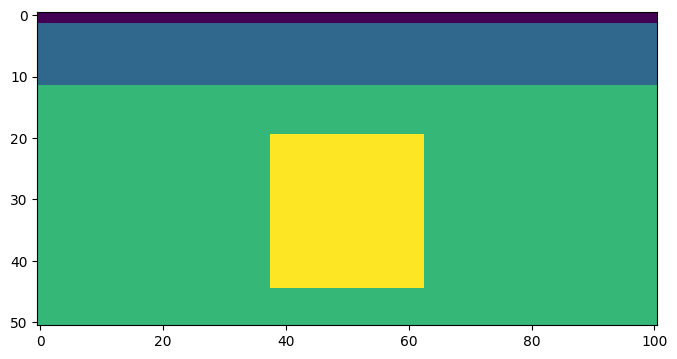

In [ ]:
#matriz de 51x101
#matriz indica qual tecido se trata
tp = np.zeros((len(x),len(y)))

for i in range(len(x)):
  for j in range(len(y)):
    '''
    tp[i][j] = 0 -> dermis
    tp[i][j] = 1 -> fat
    tp[i][j] = 2 -> muscle
    tp[i][j] = 3 -> tumor
    '''

    if(i>(12+20-13) and i<(12+20+13) and j>(50-13) and j<(50+13)):
      #tumor esfera de raio 13mm
      #centro (20,50)mm
      tp[i][j] = 3
    elif(i<2) :
      #derme 2mm
      tp[i,j] = 0
    elif(i<12) :
      #adiposo 10mm
      tp[i,j] = 1
    else :
      #muscular 38mm
      tp[i,j] = 2

np.savetxt("k",np.transpose(tp), fmt='%d')
plt.imshow(tp)
plt.savefig("Domminio.pdf")

Assim temos que a condutividade térmica, pode ser calculada usando o método do ponto do médio, então:
\begin{equation*}
  k_{i+\frac{1}{2},j} \approx \frac{2k_{i,j}+k_{i+1,j}}{k_{i,j}+k_{i+1,j}}
\end{equation*}

In [ ]:
#buscar o tipo: derme, musculo, gordura, tumor
def busca(i,j):
  return tp[i][j]

#definicao de k_i+1/2,j ou k_i,j+1/2 obtido atraves da media
def k_meio(i,j,ind,sinal) :
  '''
  ind -> 0 -> i
  ind -> 1 -> j,
  '''

  '''
  sinal -> True -> +1
  sinal -> False -> -1,
  '''

  #buscar o tipo derme, musculo, gordura, tumor
  ktp1 = int(busca(i,j))
  ktp2 = int(busca(i,j))

  #tratar fronteira
  if(ind==0 and i==50 and sinal==True):
    return (2*k[ktp1]*k[ktp2])/(k[ktp1]+k[ktp2])

  elif(ind==0 and i==0 and sinal==False):
    return (2*k[ktp1]*k[ktp2])/(k[ktp1]+k[ktp2])

  elif(ind==1 and j==100 and sinal==True):
    return (2*k[ktp1]*k[ktp2])/(k[ktp1]+k[ktp2])

  elif(ind==1 and j==0 and sinal==False):
    return (2*k[ktp1]*k[ktp2])/(k[ktp1]+k[ktp2])

  elif(ind==0 and sinal==True) :
    ktp2 = int(busca(i+1,j))
    return (2*k[ktp1]*k[ktp2])/(k[ktp1]+k[ktp2])

  elif(ind==0 and sinal==False) :
    ktp2 = int(busca(i-1,j))
    return (2*k[ktp1]*k[ktp2])/(k[ktp1]+k[ktp2])

  elif(ind==1 and sinal==True) :
    ktp2 = int(busca(i,j+1))
    return (2*k[ktp1]*k[ktp2])/(k[ktp1]+k[ktp2])

  elif(ind==1 and sinal==False) :
    ktp2 = int(busca(i,j-1))
    return (2*k[ktp1]*k[ktp2])/(k[ktp1]+k[ktp2])

\begin{equation*}
  \text{Temos que, reorganizando a equação separamos aonde a variavel } T_{i,j}
  \text { para o lado esquerdo da equação, e aonde não consta para o lado direito, então obtemos: }
\end{equation*}

Lado direito da equação, chamamos de f

\begin{equation*}
  f_{i,j} = -Qm_{i,j} - Wb_{i,j}C_bT_a
\end{equation*}

Assim de forma encontramos a equação:

\begin{equation*}
  T_{i,j} = \frac{-h^2f_{i,j} + k_{i+\frac{1}{2},j}T_{i+1,j} + k_{i-\frac{1}{2},j}T_{i-1,j} + k_{i,j+\frac{1}{2}}T_{i,j+1} + k_{i,j-\frac{1}{2}}T_{i,j-1}}{k_{i+\frac{1}{2},j} + k_{i-\frac{1}{2}} + k_{i,j+\frac{1}{2}} + k_{i,j-\frac{1}{2}} + Wb_{i,j}C_bh^2}
\end{equation*}

Implementação utilizando Jacobi:

In [ ]:
#vetor solução
u=np.ones((len(x),len(y)))*37.0 #chute inicial
u_new=np.ones((len(x),len(y)))*37.0

#funçao do lado direito f
f = np.zeros((len(x),len(y)))

Ta = 37.0

error_max = 1e-6 #erro para convergencia

from tqdm import tqdm

while (kit<k_max and error > error_max): #metodo de jacob
  for i in range(len(x)):
    for j in range(len(y)):
      #TODAS AS RELAÇÕES COM PONTOS FICTICIOS
      # uijp = 2*h*u_c+u[i,len(y)-1] if j==len(y)-1 else u[i,j+1]
      # uijm = 2*h*u_a+u[i,1] if j==0 else u[i,j-1]
      # uipj = 2*h*u_d+u[tam-1,j] if i==tam-1 else u[i+1,j]
      # uimj = 2*h*u_b+u[1,j] if i==0 else u[i-1,j]

      k_ip = k_meio(i,j,0,True) #ki+1/2
      k_im = k_meio(i,j,0,False) #ki-1/2
      k_jp = k_meio(i,j,1,True) #ki,j+1/2
      k_jm = k_meio(i,j,1,False) #ki,j-1/2
      #k_ip = k_im = k_jm = k_jp = 0.5


      #para tratar do tipo Dirichlet, devemos atribuir diretamente no ponto (x_i,y_j)
      if (i==0):
        u_new[i,j] = u_a
      else:
        #Tradando condicoes de contorno do tipo Neumann
        uijp = 2*h*u_c+u[i,len(y)-2] if j==len(y)-1 else u[i,j+1]
        uimj = 2*h*u_b+u[1,j] if i==0 else u[i-1,j]
        uipj = 2*h*u_d+u[tam-2,j] if i==tam-1 else u[i+1,j]

        uijm = u[i,j-1]

        f[i,j] = -(qm[int(busca(i,j))] + w_b(u[i][j])[int(busca(i,j))]*cb*Ta)
        u_new[i,j] = (k_ip*uipj + k_im*uimj + k_jp*uijp + k_jm*uijm - f[i,j]*h**2)/( k_ip+ k_im + k_jp + k_jm + w_b(u[i][j])[int(busca(i,j))]*cb*(h**2))

  error = np.linalg.norm(u_new-u, np.inf)/np.linalg.norm(u_new, np.inf)
  kit=kit+1
  u = np.copy(u_new)


# x, y = np.meshgrid(x, y)

# np.savetxt("vetor solucao",u)
# plt.imshow(u)

[[37.         37.         37.         ... 37.         37.
  37.        ]
 [37.0152249  37.0152287  37.01524166 ... 37.01524857 37.01523553
  37.01523166]
 [37.02958265 37.02959026 37.0296162  ... 37.02962999 37.02960391
  37.02959617]
 ...
 [37.23162014 37.23172981 37.23209979 ... 37.23229068 37.23191975
  37.2318094 ]
 [37.23177504 37.23188476 37.23225491 ... 37.23244582 37.23207474
  37.23196434]
 [37.23183976 37.23194955 37.23231977 ... 37.23251059 37.23213944
  37.23202901]]
1178 9.97290858638165e-07


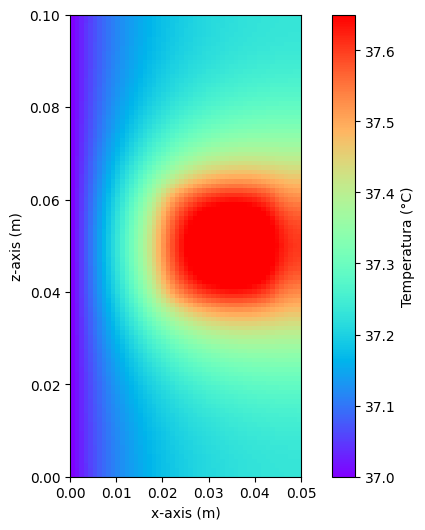

In [ ]:
print(u)

print(kit, error)
fig = plt.figure()
plt.xlabel('x-axis (m)')
plt.ylabel('Temperatura (°C)')
plt.ylabel('z-axis (m)')
plt.imshow(np.transpose(u), vmin = 37.0, vmax = 37.65, cmap = 'rainbow', interpolation = 'nearest', origin = 'lower', extent=[0,0.05,0,0.1])
plt.colorbar(label = 'Temperatura (°C)')
plt.show()

Para o resolver o problema utilizando o método de Gauss-Seidal, utilizamos o seguinte tipo de descretização:

\begin{equation*}
  -ru^{n+1}_{i-1} + (1 + 2r)u^{n+1}_i - ru^{n+1}_{i+1} = ru^n_{i-1} + (1 - 2r)u^n_i + ru^n
_{i+1} , \\
  \text {onde } r = \frac{kh}{2h^2}
\end{equation*}

\begin{equation*}
  u^{n+1}_{i,j} = (ru^n_{i-1,j} + 2(1 - 2r)u^n_i + ru^n_{i+1} + ru^{n+1}_{i+1} + u^{n+1}_i-1)/(1 + 2r)
\end{equation*}

In [ ]:
#vetor solução
u=np.ones((len(x),len(y)))*37.0 #chute inicial

u_n = np.copy(u)
kit=0
error = 1

while (kit<k_max and error > error_max): #loop da iteraçao de Gauss-Seidel
    u_old = np.copy(u)
    for i in range(len(x)): #loop sobre os pontos do espaço
      for j in range(len(y)):
        #para tratar do tipo Dirichlet, devemos atribuir diretamente no ponto (x_i,y_j)
        if (i==0):
          u_new[i,j] = u_a
        else:
          #Tradando condicoes de contorno do tipo Neumann
          uijp = 2*h*u_c+u[i,len(y)-2] if j==len(y)-1 else u[i,j+1]
          uimj = 2*h*u_b+u[1,j] if i==0 else u[i-1,j]
          uipj = 2*h*u_d+u[tam-2,j] if i==tam-1 else u[i+1,j]

          uijm = u[i,j-1]

          f[i,j] = -(qm[int(busca(i,j))] + w_b(u[i][j])[int(busca(i,j))]*cb*Ta)
          u[i,j] = (k_ip*uipj + k_im*uimj + k_jp*uijp + k_jm*uijm - f[i,j]*h**2)/( k_ip+ k_im + k_jp + k_jm + w_b(u[i][j])[int(busca(i,j))]*cb*(h**2))
          #u[i,j] = ((r*u_n[i-1] + (1-2*r)*u_n[i]+ r*u_n[i+1]) + (r*u[i-1] + r*u[i+1]))/(1+2*r)

    error = np.linalg.norm(u-u_old, np.inf)/np.linalg.norm(u, np.inf)
    kit=kit+1


[[37.         37.         37.         ... 37.         37.
  37.        ]
 [37.0152249  37.0152287  37.01524166 ... 37.01524857 37.01523553
  37.01523166]
 [37.02958265 37.02959026 37.0296162  ... 37.02962999 37.02960391
  37.02959617]
 ...
 [37.23162014 37.23172981 37.23209979 ... 37.23229068 37.23191975
  37.2318094 ]
 [37.23177504 37.23188476 37.23225491 ... 37.23244582 37.23207474
  37.23196434]
 [37.23183976 37.23194955 37.23231977 ... 37.23251059 37.23213944
  37.23202901]]
1178 9.97290858638165e-07


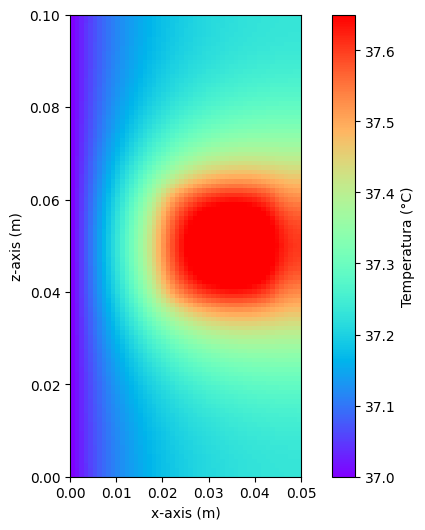

In [ ]:

print(u)

print(kit, error)
fig = plt.figure()
plt.xlabel('x-axis (m)')
plt.ylabel('Temperatura (°C)')
plt.ylabel('z-axis (m)')
plt.imshow(np.transpose(u), vmin = 37.0, vmax = 37.65, cmap = 'rainbow', interpolation = 'nearest', origin = 'lower', extent=[0,0.05,0,0.1])
plt.colorbar(label = 'Temperatura (°C)')
plt.show()